# **Assignment 2: AutoML**

Author: Aashay Pawar

NUID: 002134382

Date: February 28, 2023

Task:

In this assignment, you will an AutoML library like H2O.ai to create predictive models and interpret them. Find a significant relation for each algorithm of your choosing in your data. Create multivariate models.


Answer the following questions for all of the models:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

**About the Dataset:**

The dataset contains various details about vehicles, including car name, price in rupees, kilometers driven, fuel type, transmission type, ownership status, manufacture year, engine specifications, and number of seats. It is an open dataset that can be accessed on Kaggle, and a snapshot of the same dataset is also available on my GitHub page. The file is in CSV format, which makes it easy to import and analyze using various software tools.


Kaggle: https://www.kaggle.com/datasets/milanvaddoriya/old-car-price-prediction

Github: https://github.com/pawar-aa/NFO6105-33201-Data-Sci-Eng-Methods

**What is AutoML?**

AutoML (Automated Machine Learning) refers to the use of automated techniques and tools to automate the end-to-end process of building and deploying machine learning models. It aims to simplify and accelerate the machine learning workflow, making it accessible to non-experts and experts alike.

AutoML platforms automate the process of selecting and optimizing algorithms, hyperparameters, and data preprocessing techniques to generate a highly accurate machine learning model. AutoML tools typically involve a combination of techniques such as neural architecture search, meta-learning, and Bayesian optimization to automate the model selection and optimization process.

AutoML can help solve many challenges in machine learning, such as reducing the time and resources needed to develop a high-performing model, improving reproducibility, and enabling organizations to scale machine learning projects quickly. Overall, AutoML is a powerful tool for democratizing machine learning and making it accessible to more people.

**Problem Statement / Goal:**

Given the dataset containing information about various details of used vehicles, including car name, price in rupees, kilometers driven, fuel type, transmission type, ownership status, manufacture year, engine specifications, and number of seats, my goal is to develop a predictive model that can accurately predict used car prices.


The resulting predictive model can then be used to estimate the value of a used car, which can be useful for me as a buyer or seller. By accurately predicting the price of a used car, I can make informed decisions about the value of a car, while also helping sellers optimize their pricing strategies to maximize their profits. Overall, my goal of predicting used car prices using this dataset is to provide valuable insights into the automobile market and facilitate more informed decisions for both buyers and sellers.

In [122]:
# Installing and Initializing H2O
! pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
# Importing libraries that we are going to use in this project
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import statsmodels.api as sm
import io
from h2o.estimators import H2ORandomForestEstimator
from sklearn.ensemble import RandomForestRegressor


In [124]:
# Settings for the number of threads and maximum memory 
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 23 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_6230t1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.898 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [125]:
# Loading the dataset in a pandas data frame variable 'df' and checking the dtype
df = pd.read_csv('https://raw.githubusercontent.com/pawar-aa/NFO6105-33201-Data-Sci-Eng-Methods/main/car_price.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


In [126]:
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


**Data Cleaning and Processing:**

We can see that the dtype of most of the columns(features) is an object, possibly a string. For example, kms_driven(Kilometers driven) should be an integer, but is a string in the dataset. I shall now try to convert all possible string types to int64.

In [127]:
# CAR PRICE
# iterate over each value in the 'car_prices_in_rupee' column
for i, value in enumerate(df['car_prices_in_rupee']):
        # check if the value contains 'Lakh'
        if 'Lakh' in value:
            # replace 'Lakh' with an empty string
            value = value.replace('Lakh', '')
            # convert the value to a float
            value = int(float(value) * 100000)
        # check if the value contains 'Crore'
        elif 'Crore' in value:
            # replace 'Crore' with an empty string
            value = value.replace('Crore', '')
            # convert the value to a float
            value = int(float(value) * 10000000)
        # update the value in the dataframe
        df.at[i, 'car_prices_in_rupee'] = value
        
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].str.replace(',', '')
df['car_prices_in_rupee'] = pd.to_numeric(df['car_prices_in_rupee'], errors='coerce')
df.dropna(subset=['car_prices_in_rupee'], inplace=True)
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].astype('int64')

# KILOMETERS DRIVEN    
df['kms_driven'] = df['kms_driven'].str.replace('kms', '').str.replace(',', '').astype(int)

# FUEL TYPE
df['fuel_type'] = df['fuel_type'].str.replace('Cng', '0').str.replace('Diesel', '1').str.replace('Petrol', '2').str.replace('Electric', '3').str.replace('Lpg', '4').astype(int)

# TRANSMISSION TYPE
df['transmission'] = df['transmission'].str.replace('Manual', '0').str.replace('Automatic', '1').astype(int)

# OWNERSHIP TYPE    
df['ownership'] = df['ownership'].replace({'1st Owner': 1, '2nd Owner': 2,'3rd Owner': 3, '4th Owner': 4, '5th Owner': 5, '0th Owner': 0}).astype(int)

# ENGINE CAPACITY IN CC
df['engine'] = df['engine'].str.replace('cc', '').astype(int)

# NUMBER OF SEATS
df['Seats'] = df['Seats'].str.replace('Seats', '').astype(int)

In [128]:
# Checking the dtype of all columns now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 238 to 5439
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           123 non-null    int64 
 1   car_name             123 non-null    object
 2   car_prices_in_rupee  123 non-null    int64 
 3   kms_driven           123 non-null    int64 
 4   fuel_type            123 non-null    int64 
 5   transmission         123 non-null    int64 
 6   ownership            123 non-null    int64 
 7   manufacture          123 non-null    int64 
 8   engine               123 non-null    int64 
 9   Seats                123 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 10.6+ KB


Now, except car_name (which has a string dtype), I have converted the rest of the columns to int64 which is standard numeric type value

In [129]:
#checking null values
df.isnull().sum()

Unnamed: 0             0
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

There is no NaN values in the dataset. So the dataset is now ready for a split into training and testing sets.

**Splitting into training and testing sets:**

In [130]:
np.random.seed(0)
df_train,df_test = train_test_split(df, test_size=0.3, random_state=100)
scaler= StandardScaler()

features=['car_prices_in_rupee', 'kms_driven', 'fuel_type', 'transmission', 'ownership', 'manufacture', 'engine', 'Seats']

#scaling the training data(fitting the parameters and transforming the values)
df_train[features]=scaler.fit_transform(df_train[features])

#transforming the test data.We avoid fitting the values to prevent data leakage!
df_test[features]=scaler.transform(df_test[features])

#We will drop the Car_Name column from training and test data because it only has text info that the linear regression model can't use!
a_test=df_test.drop(columns=['car_name','car_prices_in_rupee'],axis=1)
b_test=df_test['car_prices_in_rupee']

a_train=df_train.drop(columns=['car_name','car_prices_in_rupee'],axis=1)
b_train=df_train['car_prices_in_rupee']

In [131]:
#finding dependencies of independent variable on target variable using OLS regression model

model = sm.OLS(df['car_prices_in_rupee'], df[['kms_driven', 'fuel_type', 'transmission', 'ownership', 'manufacture', 'engine', 'Seats']]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     car_prices_in_rupee   R-squared (uncentered):                   0.954
Model:                             OLS   Adj. R-squared (uncentered):              0.952
Method:                  Least Squares   F-statistic:                              347.2
Date:                 Wed, 01 Mar 2023   Prob (F-statistic):                    1.15e-74
Time:                         03:01:37   Log-Likelihood:                         -1369.5
No. Observations:                  123   AIC:                                      2753.
Df Residuals:                      116   BIC:                                      2773.
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
kms_driven       0.0070      0.042      0.166      0.869      -0.077       0.091
fuel_type     -615.7306   2982.721     -0.206      0.837   -6523.385    5291.924
transmission  8763.3788   1.77e+04      0.495      0.621   -2.63e+04    4.38e+04
ownership     1684.9257   1496.736      1.126      0.263   -1279.549    4649.401
manufacture     42.4800      6.931      6.129      0.000      28.751      56.209
engine          -2.8540      3.483     -0.820      0.414      -9.752       4.044
Seats        -1601.7216   2193.464     -0.730      0.467   -5946.153    2742.710
==============================================================================
Omnibus:                        8.122   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.514
Skew:                          -0.538   Prob(JB):                       0.0234
Kurtosis:                       2.446   Cond. No.                     9.98e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above output, we shall look at p-value. I shall be selecting only those features where p-value is less than 0.05.

However, I shall be selecting kms_driven and engine in consideration, **assuming** that the car_prices is dependent on the mentioned features.


In [132]:
# Dropping all other features and displaying first 5 rows
df.drop(labels= ['Unnamed: 0', 'car_name', 'fuel_type', 'transmission', 'ownership', 'manufacture', 'Seats'], axis= 1, inplace= True)          
df.head()

,car_prices_in_rupee,kms_driven,engine
238,99999,80000,1298
243,55000,90000,993
342,84778,70229,796
675,59000,60000,1497
734,90000,80000,2993


In [133]:
# Finding correlation
df.corr()

,car_prices_in_rupee,kms_driven,engine
car_prices_in_rupee,1.000000,0.044721,-0.082182
kms_driven,0.044721,1.000000,-0.016314
engine,-0.082182,-0.016314,1.000000


<AxesSubplot:>

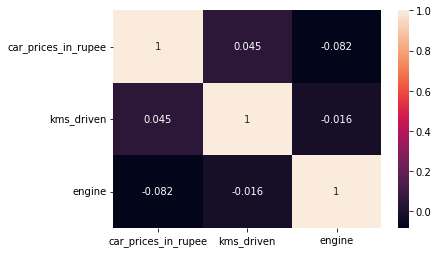

In [134]:
#plotting heatmap to check correlation of features
sns.heatmap(df.corr(),annot=True)

From the above results, if standards are unaccounted, I can say that car_prices_in_rupee is directly correlated kms_driven, transmission and inversely to engine.

In [135]:
data = h2o.H2OFrame(df)
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


car_prices_in_rupee,kms_driven,engine
99999,80000,1298
55000,90000,993
84778,70229,796
59000,60000,1497
90000,80000,2993
99205,84489,1493
60000,16700,2523
65000,60000,1998
89000,29081,2179
65000,80000,1599


In [136]:
y = "car_prices_in_rupee" 
x = data.columns

target=y

splits = data.split_frame(ratios=[0.75], seed=1)  

train = splits[0]
test = splits[1]

print ("Rows in Train",train.nrow)
print ("Rows in Test",test.nrow)

Rows in Train 98
Rows in Test 25


In [137]:
# Set up AutoML
import time
aml = H2OAutoML(max_runtime_secs=60)

# set model start time and train the aml model
model_start_time = time.time()
aml.train(x=x,y=y,training_frame=data)

AutoML progress: |
03:01:39.365: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 123.0.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20230301_30138_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    26                 26                          4380                   3            7            5.26923       7             12            8.76923

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 205039261.6530866
RMSE: 14319.192074034296
MAE: 11766.221354166666
RMSLE: 0.21831241278062008
Mean Residual Deviance: 205039261.6530866

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 271844917.80837154
RMSE: 16487.72021258159
MAE: 13532.53521122186
RMSLE: 0.2474109573415825
Mean Residual Deviance: 271844917.80837154

Cross-Validation Metrics Summary: 
                        mean         sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     13675.1      729.315     12793.7       13265.5       13925.6       13657.4       14733.4
mean_residual_deviance  2.79762e+08  2.6013e+07  2.54872e+08   2.50088e+08   2.9921e+08    2.87033e+08   3.0761e+08
mse                     2.79762e+08  2.6013e+07  2.54872e+08   2.50088e+08   2.9921e+08    2.87033e+08   3.0761e+08
r2                      -0.0589686   0.293706    0.215025      -0.0101979    -0.0227929    0.0792671     -0.556144
residual_deviance       2.79762e+08  2.6013e+07  2.54872e+08   2.50088e+08   2.9921e+08    2.87033e+08   3.0761e+08
rmse                    16711.5      781.689     15964.7       15814.2       17297.7       16942         17538.8
rmsle                   0.249519     0.019715    0.244666      0.219893      0.259896      0.272868      0.250274

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-03-01 03:02:06  0.131 sec   0                  16851.1          14003.3         2.83961e+08
    2023-03-01 03:02:06  0.136 sec   5                  16005.8          13298.2         2.56186e+08
    2023-03-01 03:02:06  0.141 sec   10                 15393.6          12733.6         2.36963e+08
    2023-03-01 03:02:06  0.145 sec   15                 14926.3          12295.8         2.22795e+08
    2023-03-01 03:02:06  0.148 sec   20                 14649.1          12081.9         2.14596e+08
    2023-03-01 03:02:06  0.152 sec   25                 14375.2          11779.3         2.06647e+08
    2023-03-01 03:02:06  0.153 sec   26                 14319.2          11766.2         2.05039e+08

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
kms_driven  3.27917e+10            1                    0.573093
engine      2.44272e+10            0.744918             0.426907

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [138]:
# printing the leaderBoard for models used
print(aml.leaderboard)

model_id                                                   rmse          mse      mae     rmsle    mean_residual_deviance
GBM_grid_1_AutoML_3_20230301_30138_model_1              16487.7  2.71845e+08  13532.5  0.247411               2.71845e+08
GBM_4_AutoML_3_20230301_30138                           16530.5  2.73259e+08  13564.9  0.246648               2.73259e+08
GBM_3_AutoML_3_20230301_30138                           16537.4  2.73487e+08  13658.2  0.247394               2.73487e+08
GBM_2_AutoML_3_20230301_30138                           16576.7  2.74788e+08  13605.7  0.247553               2.74788e+08
StackedEnsemble_AllModels_3_AutoML_3_20230301_30138     16650.7  2.77247e+08  13604    0.249208               2.77247e+08
StackedEnsemble_BestOfFamily_1_AutoML_3_20230301_30138  16664.3  2.77699e+08  13777.7  0.249443               2.77699e+08
GBM_grid_1_AutoML_3_20230301_30138_model_4              16668.3  2.77832e+08  13688.4  0.248809               2.77832e+08
GBM_grid_1_AutoML_3_2023

In [139]:
# predicting on test data
prediction = aml.leader.predict(test)
prediction.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
77059.4
70486.7
73934.7
83916
72992.8
70610.2
68625.8
73970.4
72380.1
84972


In [140]:
# Finding & storing the best model
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])
best_model.algo

'gbm'

In [141]:
# performance of the gbm model
best_model.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 156691226.29918966
RMSE: 12517.636609967141
MAE: 10170.825667955194
RMSLE: 0.18153556710347868
Mean Residual Deviance: 156691226.29918966

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_grid_1_AutoML_3_20230301_30138_model_8,4695.09,2.20438e+07,3234.87,0.0762342,2.20438e+07,33,0.007695,GBM
XGBoost_grid_1_AutoML_3_20230301_30138_model_7,5295.95,2.80471e+07,3988.02,0.0830288,2.80471e+07,1377,0.004977,XGBoost
XGBoost_grid_1_AutoML_3_20230301_30138_model_9,8184.15,6.69804e+07,6355.53,0.127055,6.69804e+07,684,0.003919,XGBoost
DRF_1_AutoML_3_20230301_30138,8663.25,7.5052e+07,6742.21,0.137109,7.5052e+07,34,0.008183,DRF
XGBoost_grid_1_AutoML_3_20230301_30138_model_5,8895.35,7.91272e+07,5517.8,0.139331,7.91272e+07,135,0.005626,XGBoost
XRT_1_AutoML_3_20230301_30138,9159.31,8.38929e+07,7206.2,0.143406,8.38929e+07,110,0.007718,DRF
XGBoost_grid_1_AutoML_3_20230301_30138_model_8,10295.9,1.06005e+08,8019.86,0.158217,1.06005e+08,230,0.00305,XGBoost
GBM_grid_1_AutoML_3_20230301_30138_model_3,10831.8,1.17328e+08,8011.42,0.170908,1.17328e+08,23,0.004469,GBM
XGBoost_3_AutoML_3_20230301_30138,11034.8,1.21767e+08,8554.89,0.168972,1.21767e+08,39,0.004005,XGBoost
GBM_5_AutoML_3_20230301_30138,11147.9,1.24276e+08,8613.57,0.174839,1.24276e+08,28,0.007461,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

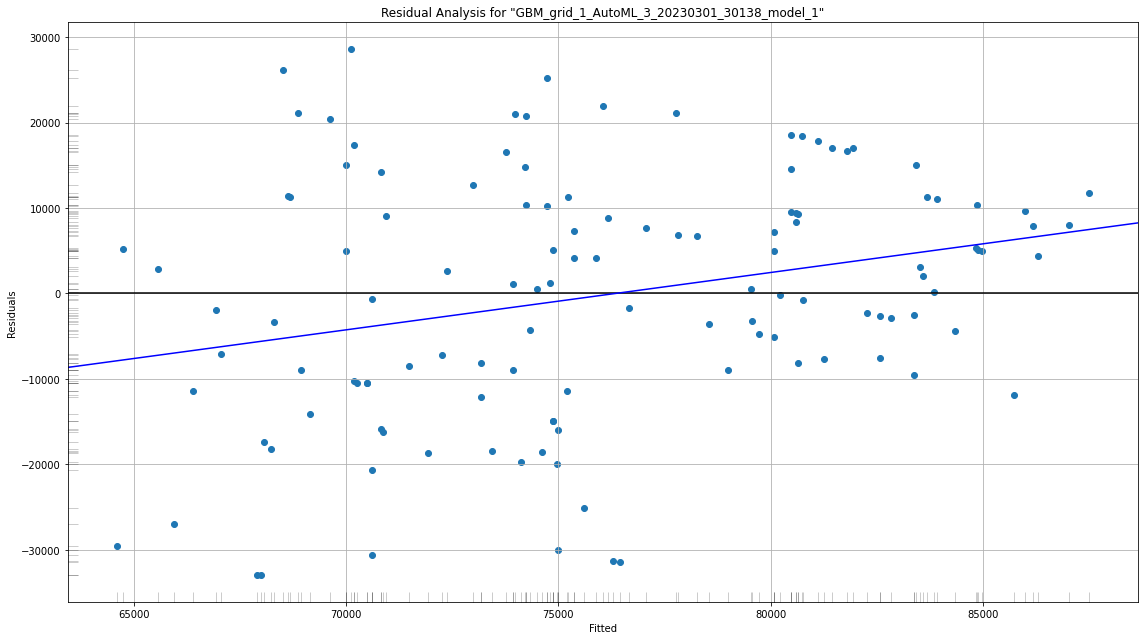

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

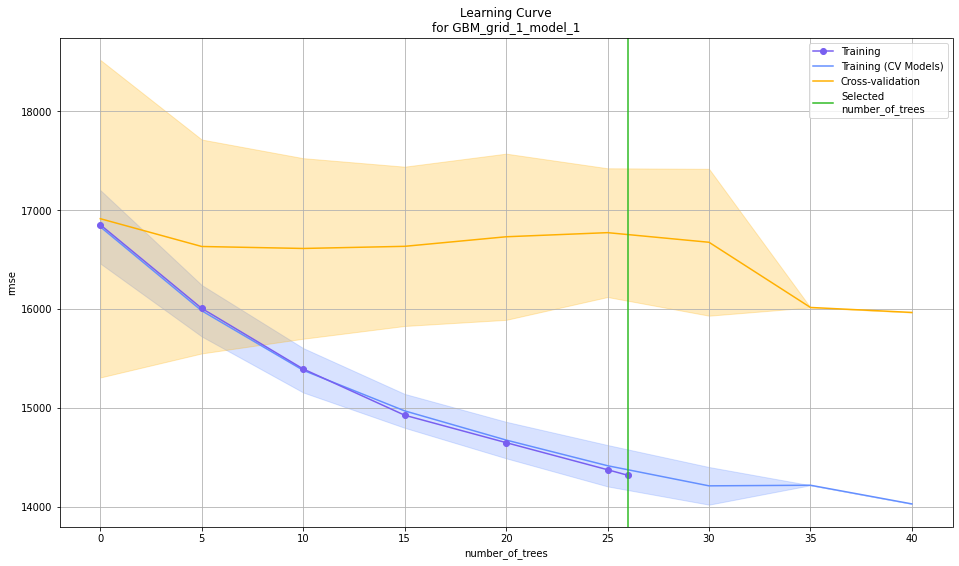

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

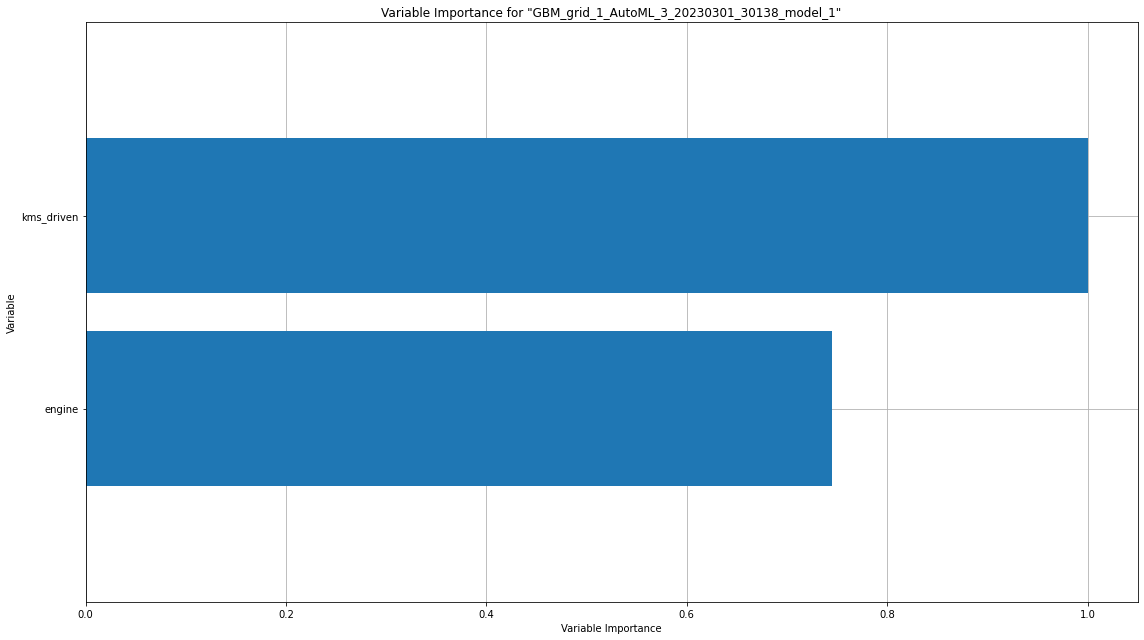

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

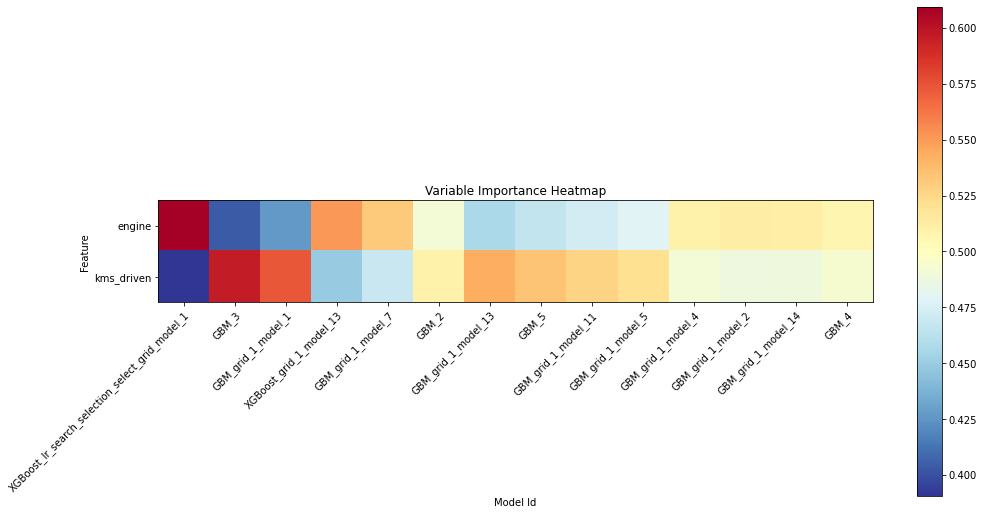

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

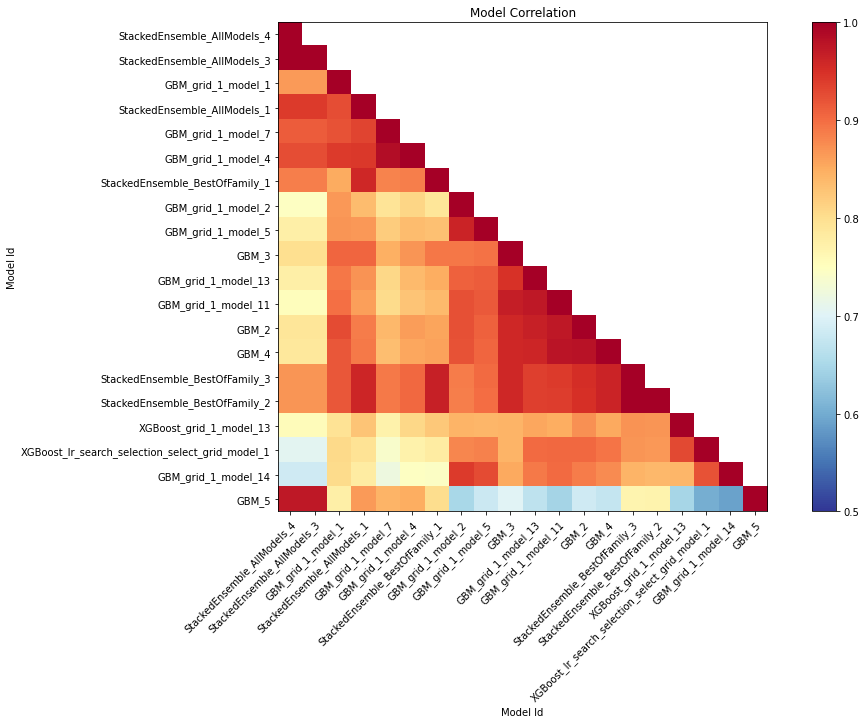

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

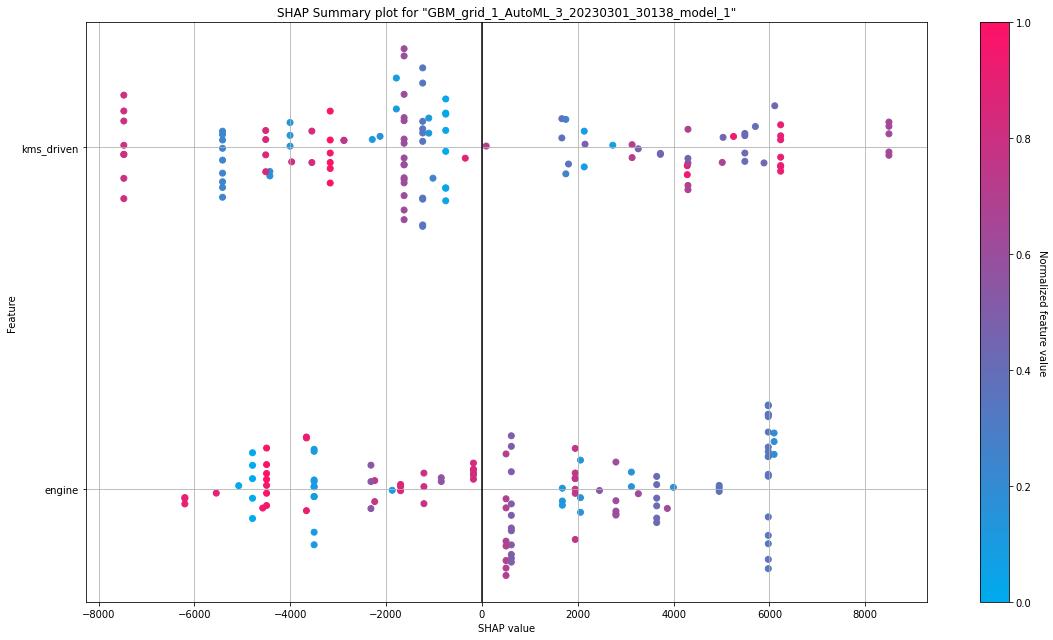

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

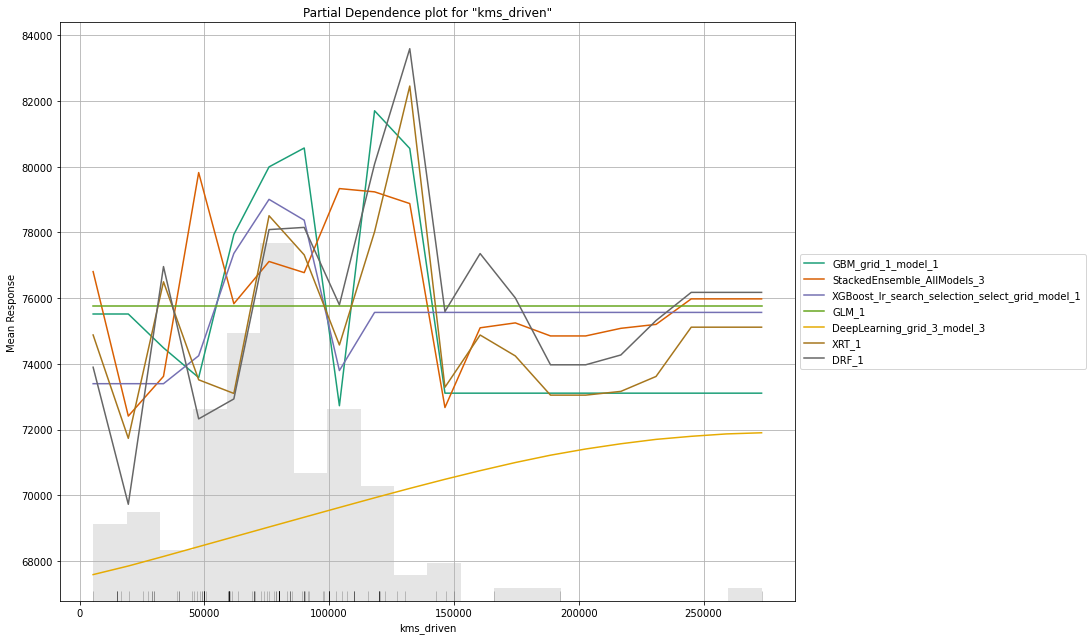

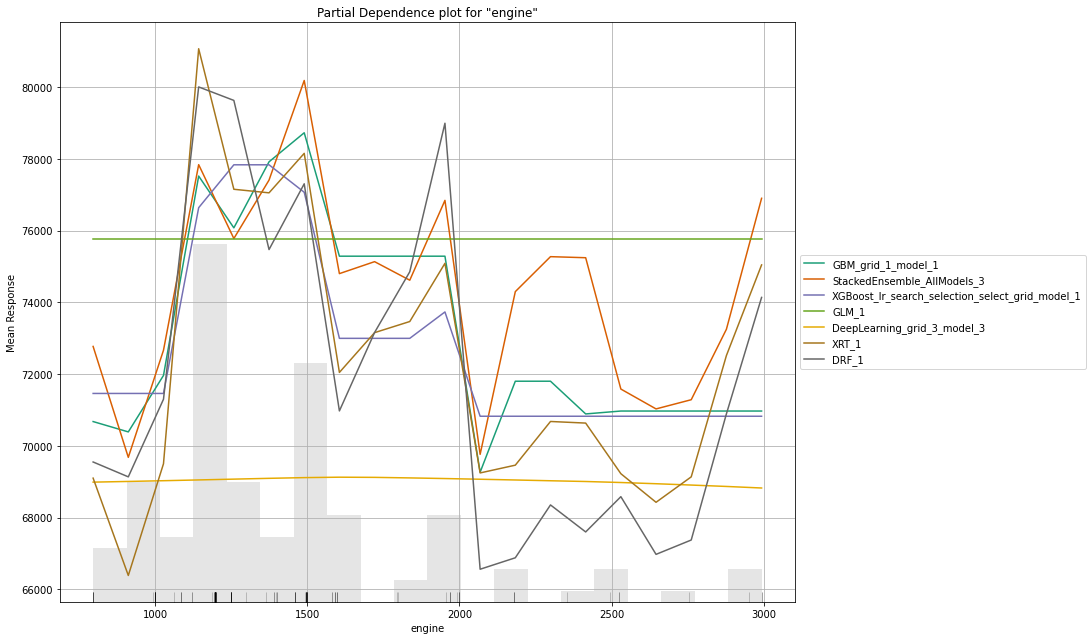

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

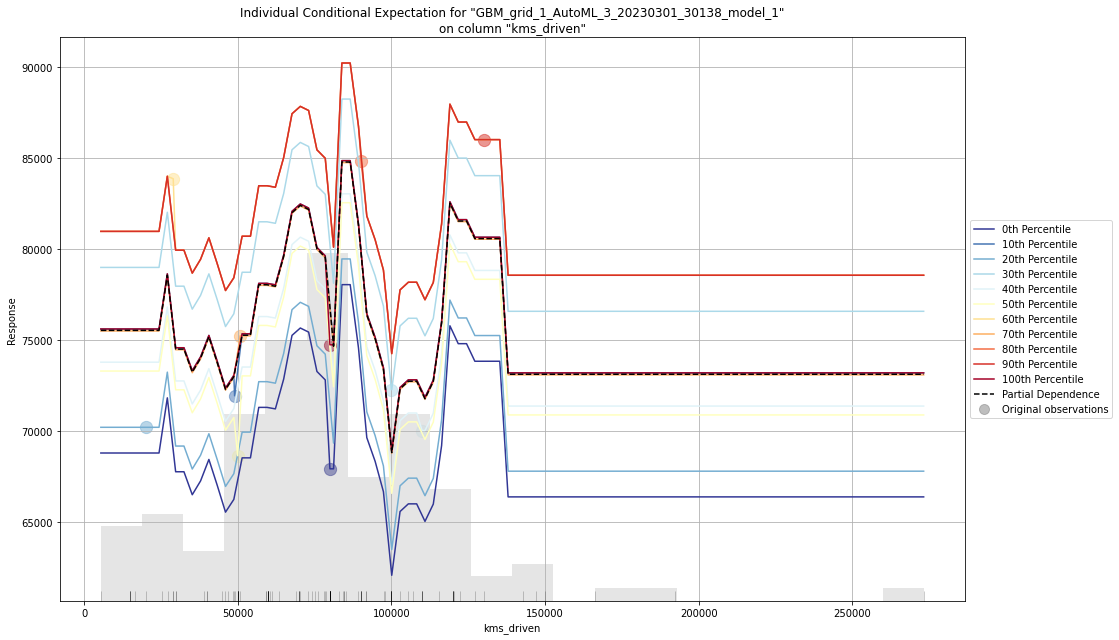

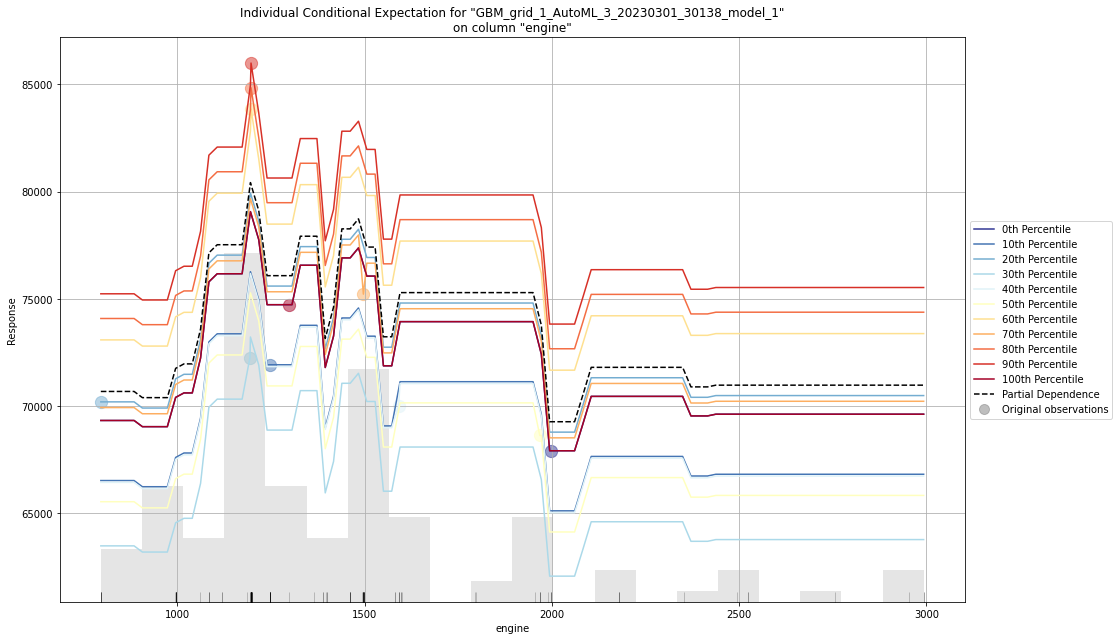

In [142]:
model_explain = aml.explain(data)

In [143]:
regressor = RandomForestRegressor()

## Hyperparameters 
# number of trees
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]

# number of features
max_features = ['auto', 'sqrt']

# max number of levels in tree
max_depth = [int(x) for x in np.linspace(start= 5, stop= 30, num= 6)]

# min. number of sample required to split a node
min_samples_split = [2,5,10,15,100]

# min. number of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

#Create the random grid
random_grid= {'n_estimators': n_estimators, 
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


**Q/A:**

Answer the following questions for all of the models:

* Is the relationship significant? No, the relationship is insignificant as the strength of evidence against the null hypothesis was more than 0.05. The results are not statistically significant. This does not necessarily mean there is no difference. It could be that the sample size is too small, or the effect size is small, or there is too much variability in the data, which makes it difficult to detect a significant difference

* Are any model assumptions violated? No

* Is there any multicollinearity in the model? Yes. I detected multicollinearity by analyzing the correlation matrix and by examining the p-values of all variables. In the present study, the OLS summary indicated that the p-values for multiple features were greater than 0.05, suggesting that these variables are not significant. Upon rechecking the values, the model met the expected output. Thus, it was concluded that these unnecessary variables were causing multicollinearity and their removal improved the model's performance.

* In the multivariate models are predictor variables independent of all the other predictor variables? By referring to correlation matrix and heat map, the variables were independent of all other predictor variables as none of the values were more than 0.2 or less than -0.2.

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model. Most significant was kms_driven and most insignificant was engine

* Does the model make sense? No, the model seems imperfect for the proposed solution as RMS and p-values are not as expected.

* Does regularization help? No, regularization would be ineffective.

* Which independent variables are significant? None of them are significant. However, closest were kms_driven

* Which hyperparameters are important? To optimize the performance of the model, a RandomForestRegressor is employed. The hyperparameters used for tuning the model include 'max_depth' of 30, 'min_samples_split' of 2, and 'n_estimators' of 100.



**References:**


1. https://www.kaggle.com/datasets/milanvaddoriya/old-car-price-prediction/code
2. https://www.w3schools.com/python/pandas/
3. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb




MIT License

Copyright (c) 2023 Aashay Pawar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.